# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model
from matplotlib import pyplot as pl
from skimage import exposure
from skimage.feature import hog
from sklearn import metrics as me

from utils import plot_confusion_matrix

%matplotlib inline

2023-04-30 22:27:35.940944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 22:27:36.379334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [3]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [4]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

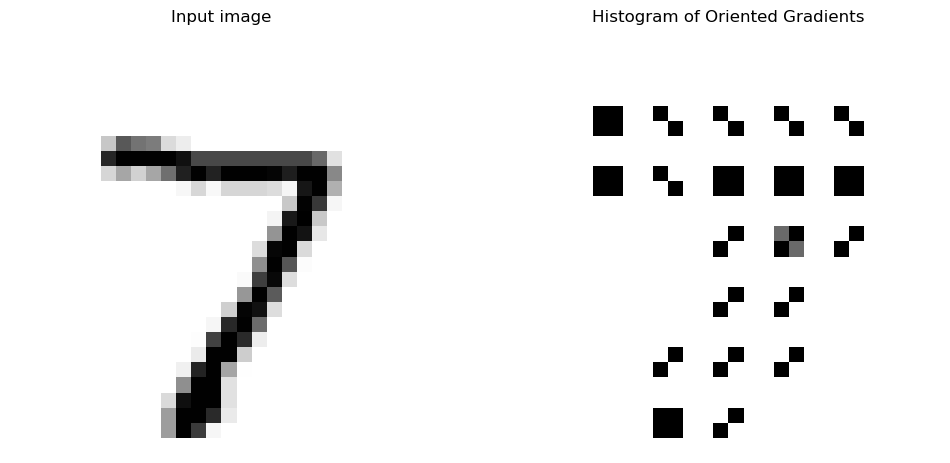

In [5]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [6]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [7]:
model = Sequential([
    Dense(200, input_shape=(hog_size,), activation='relu'),
    #Dropout(0.25),
    Dense(n_classes, activation='softmax'),
])

model.summary()

2023-04-30 22:28:15.092105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:28:15.102140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:28:15.102188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               78600     
                                                                 
 dense_1 (Dense)             (None, 10)                2010      
                                                                 
Total params: 80,610
Trainable params: 80,610
Non-trainable params: 0
_________________________________________________________________


2023-04-30 22:28:15.104565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:28:15.104610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:28:15.104641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:28:15.544512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:28:15.544592: I tensorflow/compile

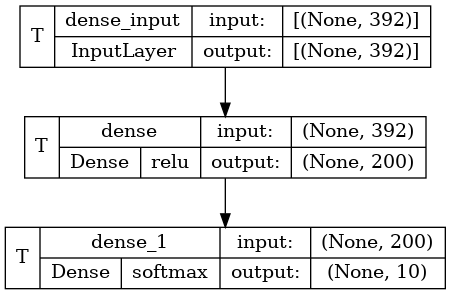

In [8]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
    to_file='mlpf-model.png'
)

Define some constants and train the MLP

In [9]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/10
 16/422 [>.............................] - ETA: 4s - loss: 1.5257 - accuracy: 0.7007

2023-04-30 22:28:36.736541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


422/422 [==============================] - 7s 7ms/step - loss: 0.2401 - accuracy: 0.9429 - val_loss: 0.0853 - val_accuracy: 0.9747
Epoch 2/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0925 - accuracy: 0.9706 - val_loss: 0.0808 - val_accuracy: 0.9755
Epoch 3/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0771 - accuracy: 0.9748 - val_loss: 0.0710 - val_accuracy: 0.9782
Epoch 4/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0665 - accuracy: 0.9789 - val_loss: 0.0652 - val_accuracy: 0.9783
Epoch 5/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0590 - accuracy: 0.9810 - val_loss: 0.0617 - val_accuracy: 0.9800
Epoch 6/10
422/422 [==============================] - 3s 7ms/step - loss: 0.0521 - accuracy: 0.9835 - val_loss: 0.0644 - val_accuracy: 0.9803
Epoch 7/10
422/422 [==============================] - 3s 8ms/step - loss: 0.0458 - accuracy: 0.9856 - val_loss: 0.0701 - val_accuracy: 0.9798
Epoch 8/10
422/42

Show the performance of the model

Test score: 0.06721501797437668
Test accuracy: 0.9786999821662903


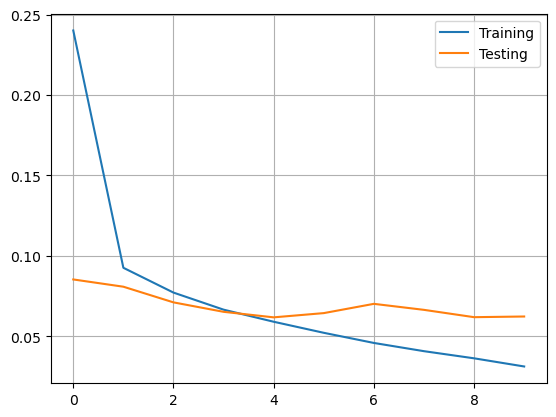

In [10]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 [==============================] - 0s 1ms/step


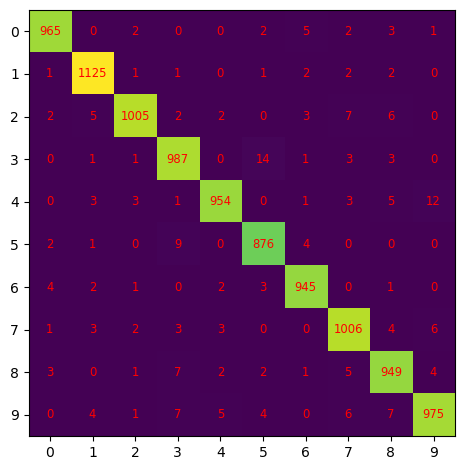

F-score 0: 0.9856996935648621
F-score 1: 0.9872751206669592
F-score 2: 0.9809663250366031
F-score 3: 0.9738529847064629
F-score 4: 0.9784615384615385
F-score 5: 0.9765886287625417
F-score 6: 0.9843749999999999
F-score 7: 0.9757516973811833
F-score 8: 0.9713408393039917
F-score 9: 0.9715994020926756


In [11]:
pred = np.argmax(model.predict(X_test_hog), axis=-1)
cm = me.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])